# Environment

In [3]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, map_name="4x5", is_slippery=True, slip_prob=0.2):
        self.map_name = map_name
        self.is_slippery = is_slippery
        self.slip_prob = slip_prob

        self.desc = np.asarray(["SFFFF", "FHFHF", "FFFFF", "HFFFG"], dtype="c")

        self.nrow, self.ncol = self.desc.shape
        self.nA = 4
        self.nS = self.nrow * self.ncol

        self.P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        self._init_transitions()

        self.observation_space = Discrete(self.nS)
        self.action_space = Discrete(self.nA)

        self.reset()

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == 0:  # left
            col = max(col - 1, 0)
        elif a == 1:  # down
            row = min(row + 1, self.nrow - 1)
        elif a == 2:  # right
            col = min(col + 1, self.ncol - 1)
        elif a == 3:  # up
            row = max(row - 1, 0)
        return (row, col)

    def _init_transitions(self):
        for row in range(self.nrow):
            for col in range(self.ncol):
                s = self.to_s(row, col)
                for a in range(self.nA):
                    li = self.P[s][a]
                    letter = self.desc[row, col]
                    if letter in b"GH":
                        li.append((1.0, s, 0, True))
                    else:
                        if self.is_slippery:
                            for b in [(a - 1) % 4, a, (a + 1) % 4]:
                                newrow, newcol = self.inc(row, col, b)
                                newstate = self.to_s(newrow, newcol)
                                newletter = self.desc[newrow, newcol]
                                done = bytes(newletter) in b"GH"
                                rew = float(newletter == b"G")
                                prob = (
                                    self.slip_prob / 2 if b != a else 1 - self.slip_prob
                                )
                                li.append((prob, newstate, rew, done))
                        else:
                            newrow, newcol = self.inc(row, col, a)
                            newstate = self.to_s(newrow, newcol)
                            newletter = self.desc[newrow, newcol]
                            done = bytes(newletter) in b"GH"
                            rew = float(newletter == b"G")
                            li.append((1.0, newstate, rew, done))

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = 0
        return self.s, {}

    def step(self, a):
        transitions = self.P[self.s][a]
        i = np.random.choice(len(transitions), p=[t[0] for t in transitions])
        prob, s, rew, done = transitions[i]
        self.s = s
        return s, rew, done, False, {}

# Plots functions

In [4]:
def plot_value_function(V, title="Value Function"):
    V = V.reshape((4, 5))
    plt.figure(figsize=(6, 6))
    sns.heatmap(V, annot=True, cmap="coolwarm", cbar=False, square=True, linewidths=0.5)
    plt.title(title)
    plt.show()


def plot_policy(P, title="Policy"):
    P = np.array(P).reshape((4, 5))
    policy_arrows = np.array([["←", "↓", "→", "↑"][a] for a in P.flatten()]).reshape(
        (4, 5)
    )
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        np.zeros((4, 5)),
        annot=policy_arrows,
        fmt="",
        cbar=False,
        square=True,
        linewidths=0.5,
    )
    plt.title(title)
    plt.show()

## Policy/value functions

In [5]:
def value_iteration(env, gamma=0.99, theta=1e-8):
    V = np.zeros(env.nS) # Initialize value
    policy = np.zeros(env.nS, dtype=int) # Initialize Policy
    i=0 # num of iterations
    while (True):
      i+=1
      d=0

      # For any state
      for s in range(env.nS):
        v_curr = V[s] # Temporal state's value
        Q_s = np.zeros(env.nA)

        # For any action possible from the state
        for a in range(env.nA):
            for prob, next_s, reward, done in env.P[s][a]: # For any probability and reward to move from s by action a
                Q_s[a] += prob * (reward + gamma * V[next_s])
        V[s] = np.max(Q_s) # Maximum value from the actions
        policy[s] = np.argmax(Q_s) # The action that gave the maximum value
        d = max(d, abs(v_curr - V[s]))
      if d<theta:
        print("Total iterations: ", i)
        V[19]=1
        break

    return policy, V



def sarsa(env, alpha=0.1, gamma=0.99, epsilon=0.1, num_episodes=5000):
    Q = np.zeros((env.nS, env.nA))

    for i in range(num_episodes):
        state, _ = env.reset()
        done = False # Boolean if the episode is done

        # Evaluating an episode
        while not done: # Done if episode arrived to H or G
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            prev=state
            state = next_state
            action2 = epsilon_greedy(Q, next_state, epsilon)
            Q[prev, action] +=  alpha * (reward + gamma*Q[next_state, action2] - Q[prev, action])

    policy = np.argmax(Q, axis=1) # Policy is the action given the best reward at any state
    return policy, Q


def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])


def monte_carlo_glie(env, alpha=0.1, gamma=0.99, num_episodes=5000):
    Q = np.zeros((env.nS, env.nA))

    for i in range(1, num_episodes + 1):
        epsilon = 1.0 / i  # Decaying epsilon
        state, _ = env.reset()
        episode = []
        done = False # Boolean if the episode is done

        # Evaluating an episode
        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        # Update Q using the episode
        G = 0
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            Q[state, action] += alpha * (G - Q[state, action])

    policy = np.argmax(Q, axis=1) # Policy is the action given the best reward at any state
    return policy, Q


def q_learning(env, alpha=0.1, gamma=0.99, epsilon=0.1, num_episodes=5000):
    Q = np.zeros((env.nS, env.nA))

    for i in range(num_episodes):
        state, _ = env.reset()
        done = False # Boolean if the episode is done

        # Evaluating an episode
        while not done: # Done if episode arrived to H or G
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done, _, _ = env.step(action)
            prev=state
            state = next_state

            Q[prev, action] +=  alpha * (reward + gamma*np.max(Q[next_state]) - Q[prev, action]) # Maximun reward on next_state actions, in contrast to sarsa

    policy = np.argmax(Q, axis=1) # Policy is the action given the best reward at any state
    return policy, Q


def policy_iteration(env, gamma=0.99, theta=1e-8):
    V = np.zeros(env.nS) # Initialize Value
    policy = np.zeros(env.nS, dtype=int) # Initialize Policy
    i=0 # num of iterations
    while (True):
      i+=1
      V_temp = np.zeros(env.nS) # Temporal initialization

      # For any state
      for s in range(env.nS):
        v_policy = 0 # Initialize current state's value

        # For any probability and reward to move from s by action of policy at s
        for prob, next_s, reward, done in env.P[s][policy[s]]:
          v_policy += prob * (reward + gamma * V[next_s])

        # Insert to temporal the current policy if policy is better
        if v_policy>V_temp[s]:
          V_temp[s]=v_policy

      V = V_temp # Insert the temporal policy , note that V>=V_temp every iteration
      policy_stable = True

      #Evaluating the new policy
      for s in range(env.nS):
          old_action = policy[s]
          action_values = np.zeros(env.nA)
          for a in range(env.nA):
              for prob, next_s, reward, done in env.P[s][a]: # For any probability and reward to move from s by action a
                  action_values[a] += prob * (reward + gamma * V[next_s])
          policy[s] = np.argmax(action_values) # Take the best action
          if old_action != policy[s]: # If best action possible hasn't been changed
            policy_stable = False
      if policy_stable: # If all states haven't been changed, policy reached stability
          print("Total iterations: ", i)
          V[19]=1
          break

    return policy, V

Total iterations:  156


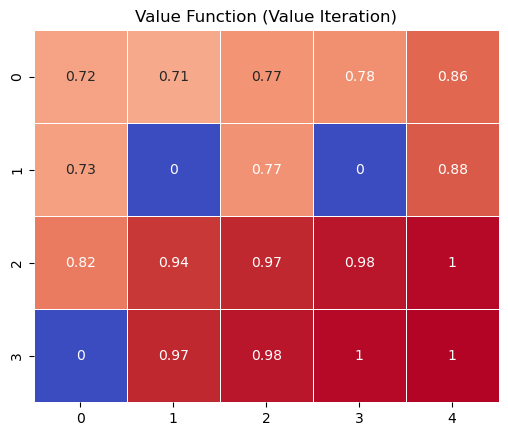

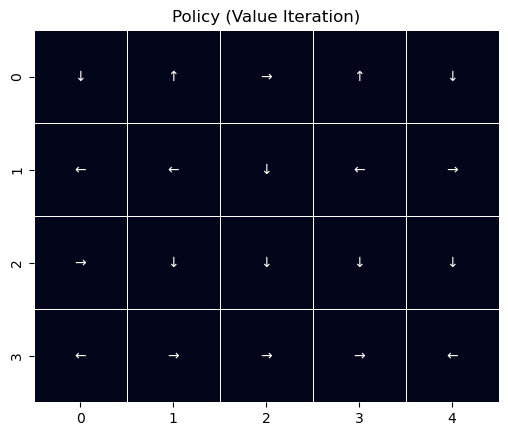

In [18]:
env = CustomFrozenLakeEnv()
policy_vi, V_vi = value_iteration(env)
plot_value_function(V_vi, title="Value Function (Value Iteration)")
plot_policy(policy_vi, title="Policy (Value Iteration)")

Total iterations:  7


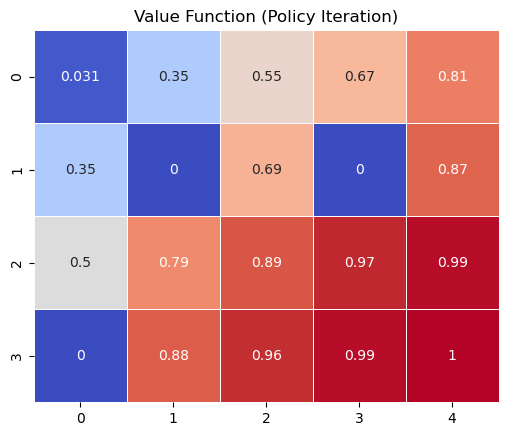

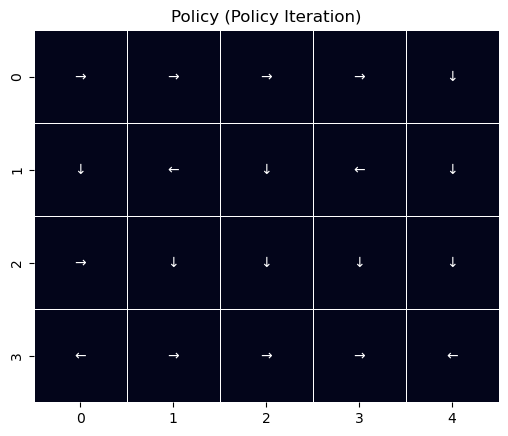

In [19]:
env = CustomFrozenLakeEnv()
policy_vi, V_vi = policy_iteration(env)
plot_value_function(V_vi, title="Value Function (Policy Iteration)")
plot_policy(policy_vi, title="Policy (Policy Iteration)")

## Monte Carlo Evaluation

alpha= 0.1
Didn't converge
alpha= 0.2
Didn't converge
alpha= 0.3
Didn't converge
alpha= 0.4


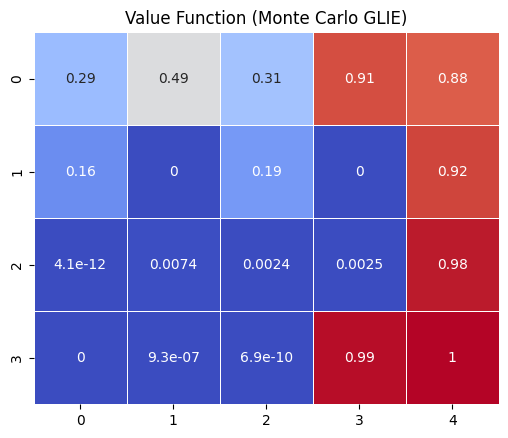

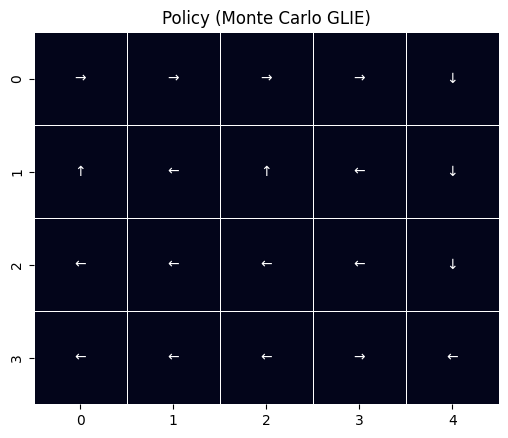

alpha= 0.5
Didn't converge
alpha= 0.6
Didn't converge
alpha= 0.7
Didn't converge
alpha= 0.8
Didn't converge
alpha= 0.9
Didn't converge
alpha= 1.0
Didn't converge


In [17]:
for i in range(1,11):
  alpha_n = i/10
  env = CustomFrozenLakeEnv()
  policy, Q = monte_carlo_glie(env,alpha=alpha_n)
  V = np.max(Q, axis=1)
  V[19]=1
  print("alpha=",alpha_n)
  if V[0]>0:
    plot_value_function(V, title="Value Function (Monte Carlo GLIE)")
    plot_policy(policy, title="Policy (Monte Carlo GLIE)")
  else:
    print("Didn't converge")

## Sarsa Evaluation

epsilon= 0.1
Didn't converge
epsilon= 0.2
Didn't converge
epsilon= 0.3
Didn't converge
epsilon= 0.4


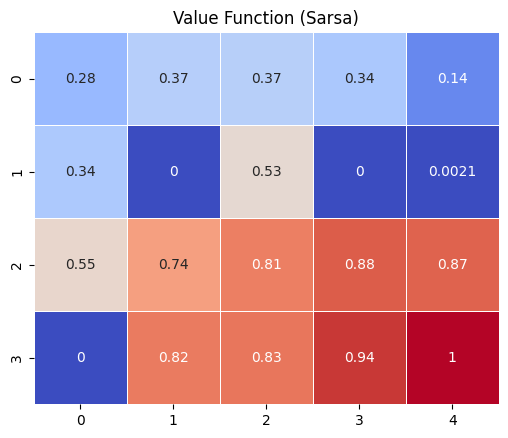

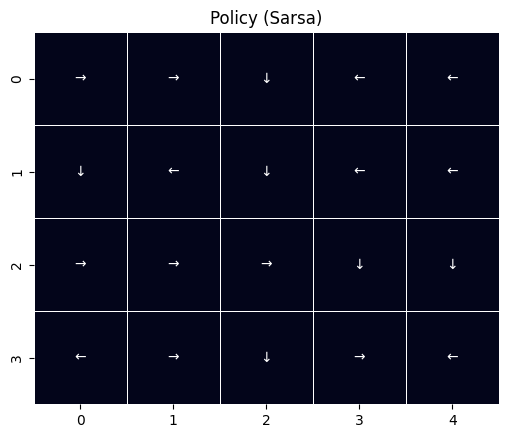

epsilon= 0.5


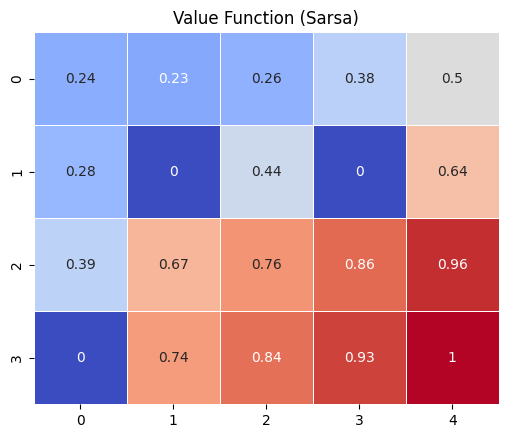

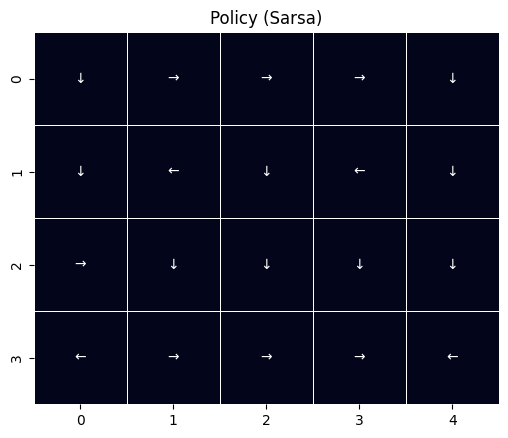

epsilon= 0.6


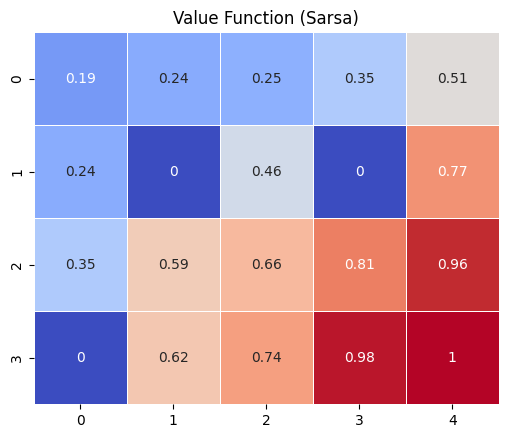

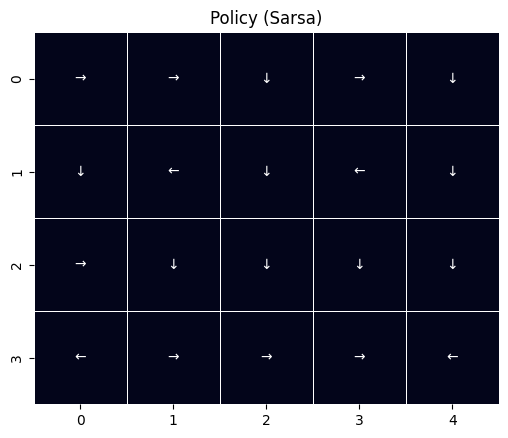

epsilon= 0.7


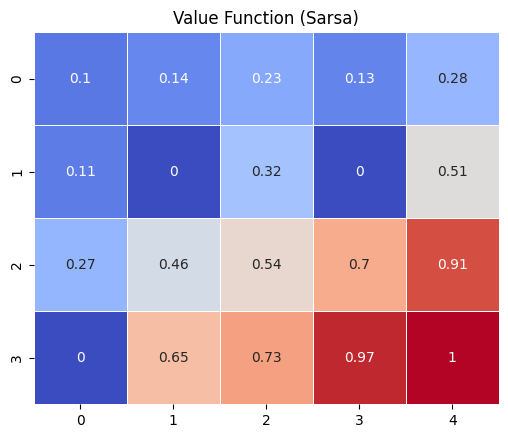

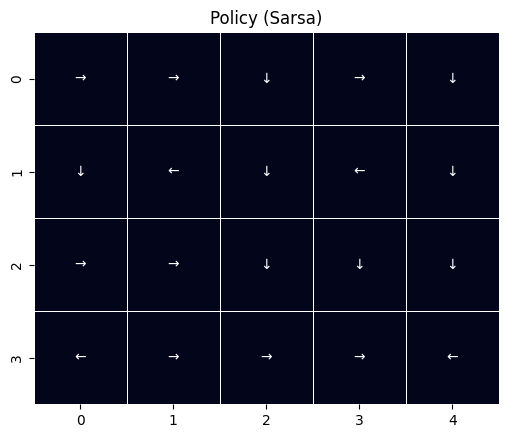

epsilon= 0.8


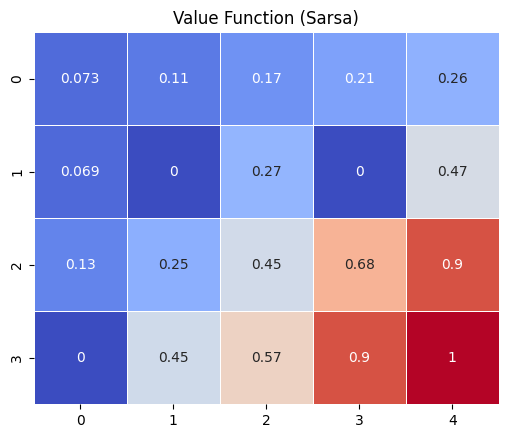

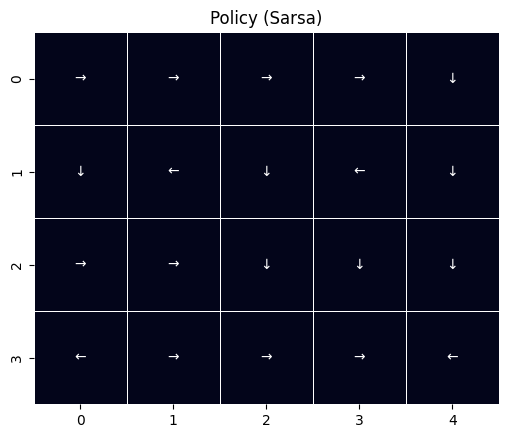

epsilon= 0.9


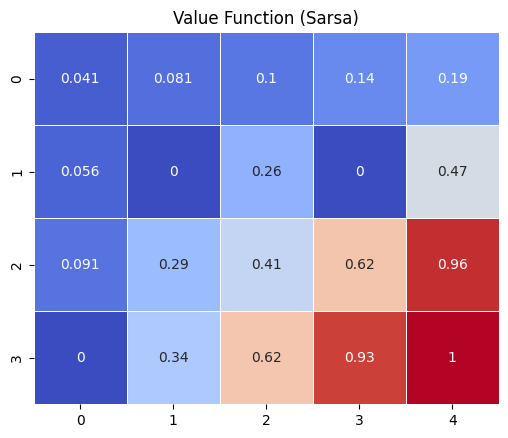

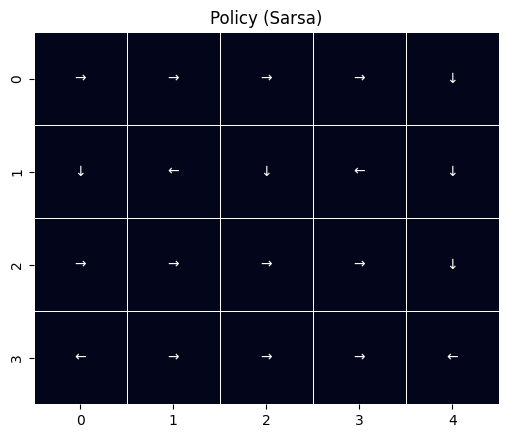

epsilon= 1.0


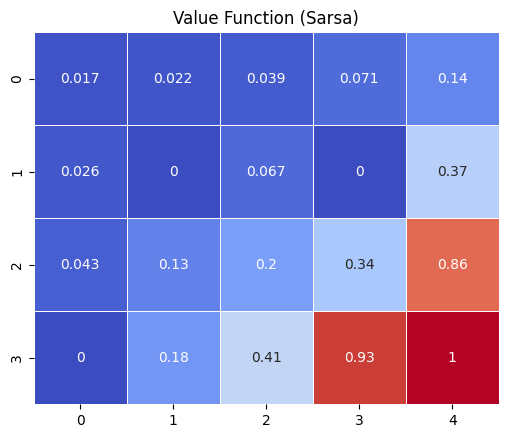

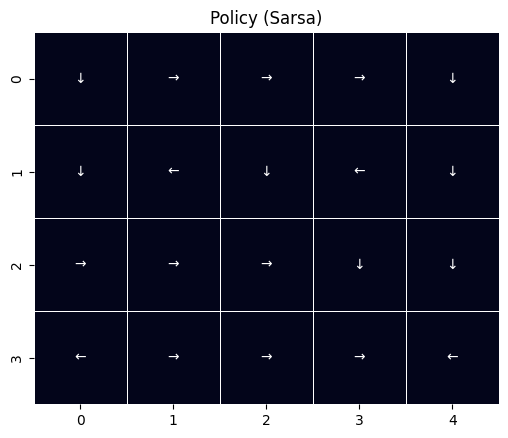

In [14]:
for j in range(1,11):
  env = CustomFrozenLakeEnv()
  eps = j/10
  print("epsilon=",eps)
  policy_sarsa, Q_sarsa = sarsa(env,epsilon=eps)
  V=np.max(Q_sarsa, axis=1)
  V[19]=1
  if V[0] > 0:
    plot_value_function(V, title="Value Function (Sarsa)")
    plot_policy(policy_sarsa, title="Policy (Sarsa)")
  else:
    print("Didn't converge")

## Q-Learning Evaluation

epsilon= 0.1
Didn't converge
epsilon= 0.2
Didn't converge
epsilon= 0.3
Didn't converge
epsilon= 0.4
Didn't converge
epsilon= 0.5


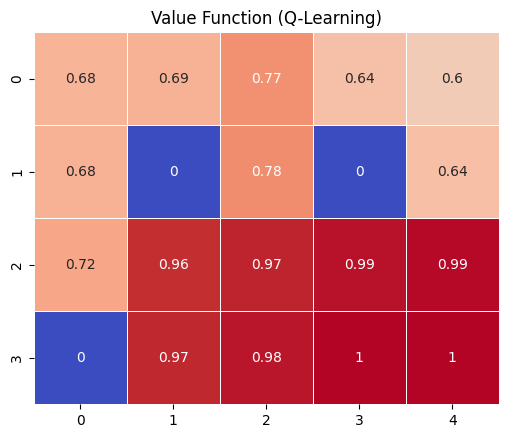

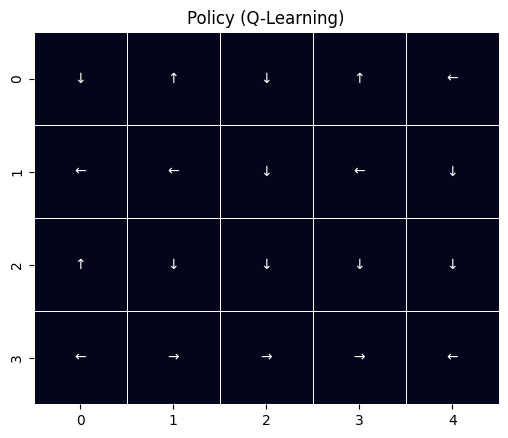

epsilon= 0.6


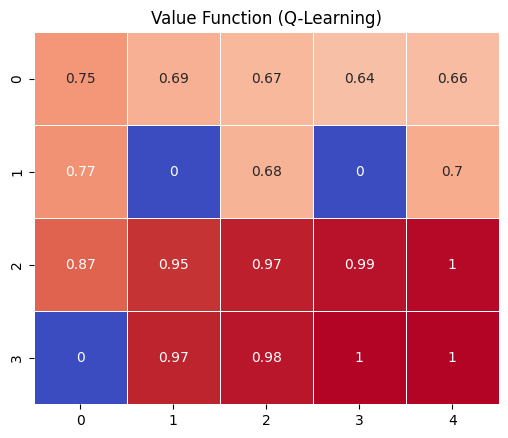

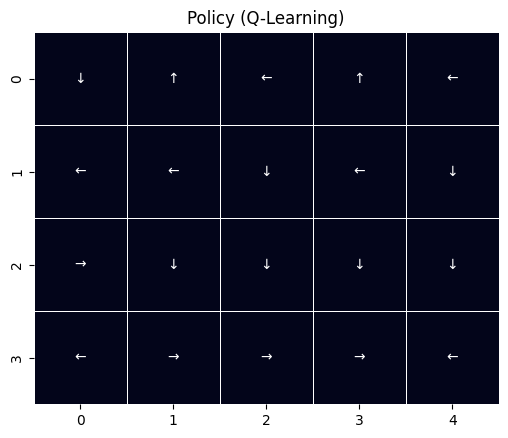

epsilon= 0.7


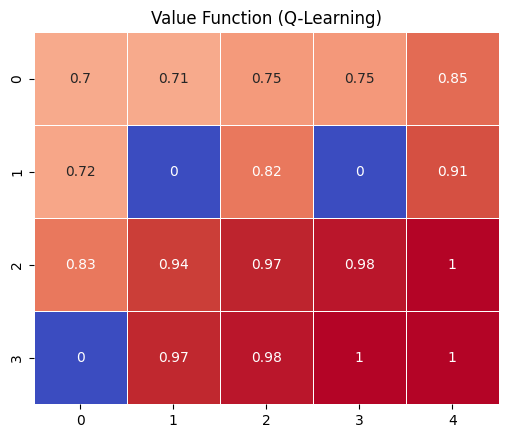

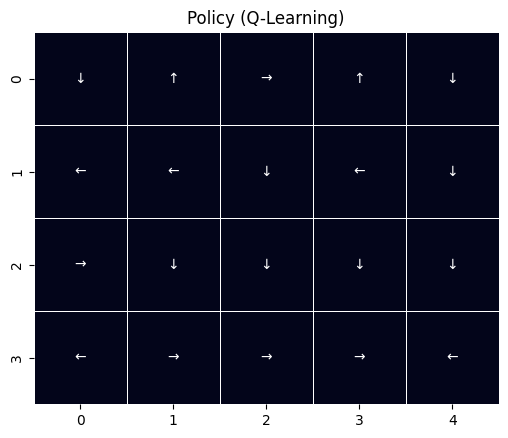

epsilon= 0.8


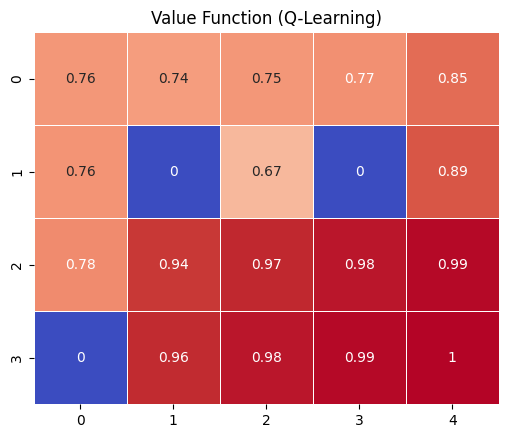

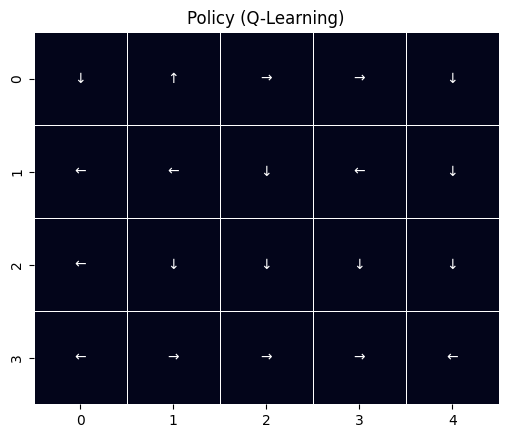

epsilon= 0.9


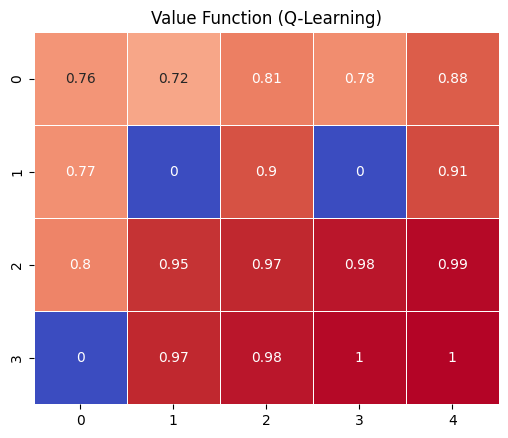

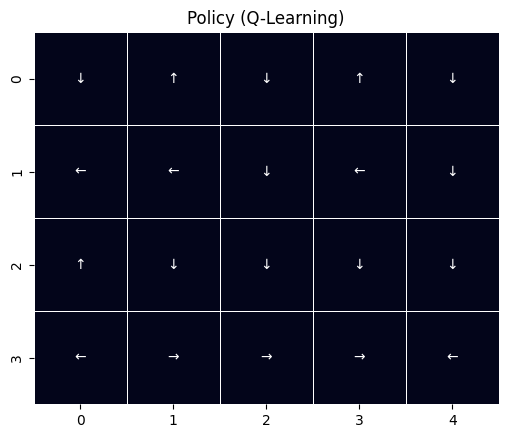

epsilon= 1.0


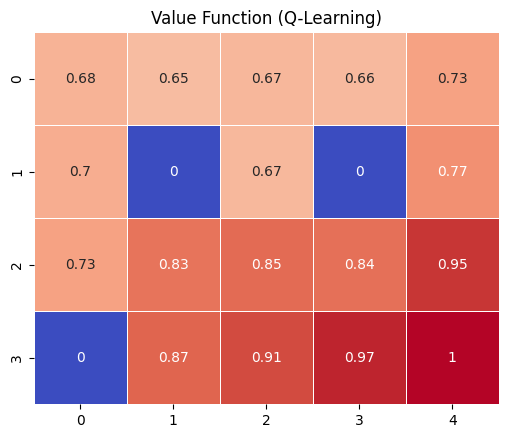

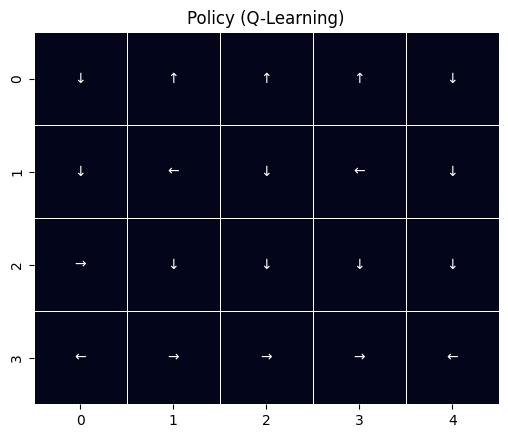

In [15]:
for j in range(1,11):
  env = CustomFrozenLakeEnv()
  eps = j/10
  print("epsilon=",eps)
  policy_q, Q_q = q_learning(env,epsilon=eps)
  V=np.max(Q_q, axis=1)
  V[19]=1
  if V[0] > 0:
    plot_value_function(V, title="Value Function (Q-Learning)")
    plot_policy(policy_q, title="Policy (Q-Learning)")
  else:
    print("Didn't converge")

## Optimal value policy graphs

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nS to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nS` for environment variables or `env.get_wrapper_attr('nS')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_wrapper_attr('P')` that will search the reminding wrappers.
  logger.warn(


Total iterations:  156


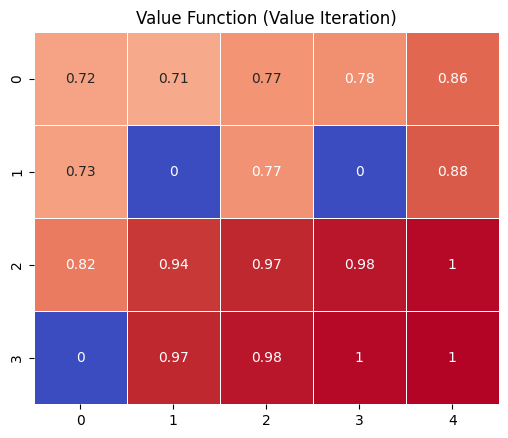

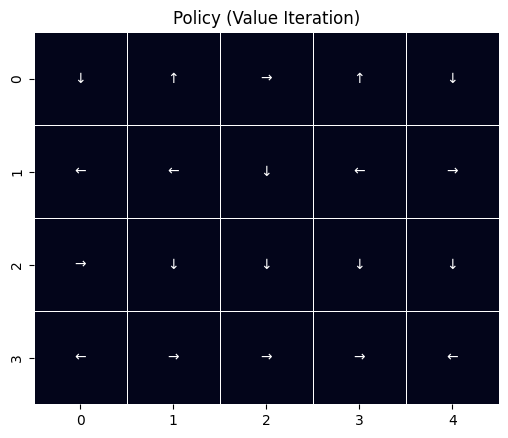

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nS to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nS` for environment variables or `env.get_wrapper_attr('nS')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


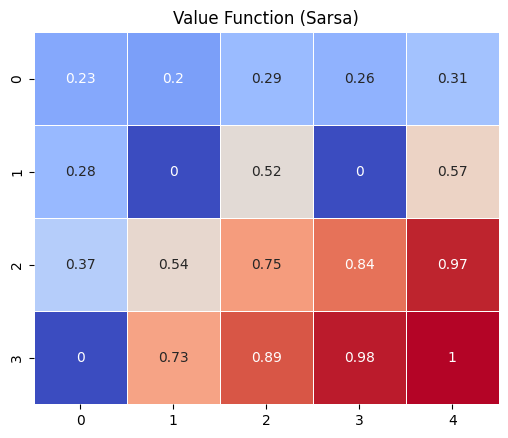

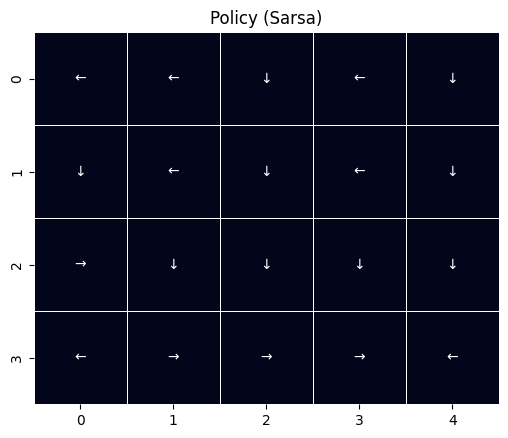

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nS to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nS` for environment variables or `env.get_wrapper_attr('nS')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


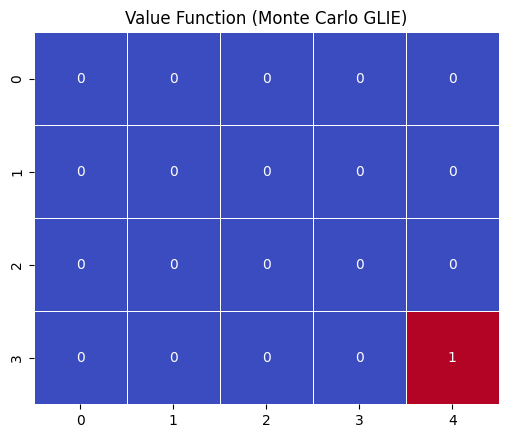

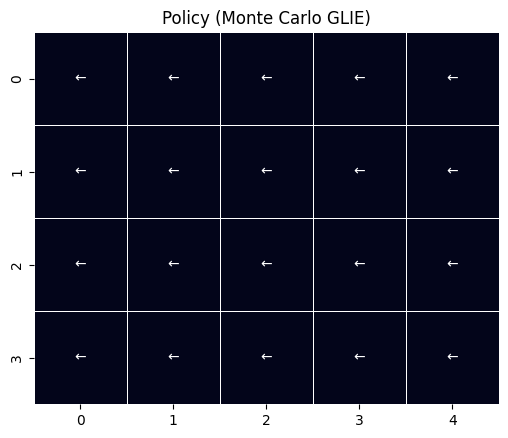

/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nS to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nS` for environment variables or `env.get_wrapper_attr('nS')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.nA to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nA` for environment variables or `env.get_wrapper_attr('nA')` that will search the reminding wrappers.
  logger.warn(


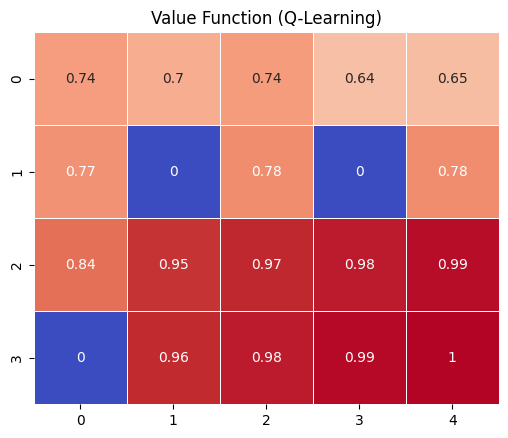

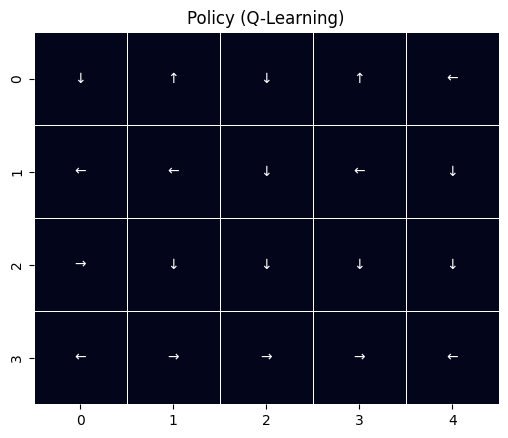

In [18]:
if __name__ == "__main__":

    # Register the custom Frozen Lake environment
    gym.envs.registration.register(
        id="CustomFrozenLake-v0",
        entry_point=__name__ + ":CustomFrozenLakeEnv",
    )

    # Create the environment
    env = gym.make("CustomFrozenLake-v0", is_slippery=True, slip_prob=0.2)

    # Run Value Iteration
    policy_vi, V_vi = value_iteration(env)
    plot_value_function(V_vi, title="Value Function (Value Iteration)")
    plot_policy(policy_vi, title="Policy (Value Iteration)")
    #
    # Run Sarsa
    policy_sarsa, Q_sarsa = sarsa(env,epsilon=0.5)
    V_sarsa=np.max(Q_sarsa, axis=1)
    V_sarsa[19]=1
    plot_value_function(V_sarsa, title="Value Function (Sarsa)")
    plot_policy(policy_sarsa, title="Policy (Sarsa)")
    #
    # Run Monte Carlo GLIE
    policy_mc, Q_mc = monte_carlo_glie(env,alpha=0.4)
    V_mc=np.max(Q_mc, axis=1)
    V_mc[19]=1
    plot_value_function(V_mc, title="Value Function (Monte Carlo GLIE)")
    plot_policy(policy_mc, title="Policy (Monte Carlo GLIE)")
    # Run Q-Learning
    policy_q, Q_q = q_learning(env,epsilon=0.7)
    V_q=np.max(Q_q, axis=1)
    V_q[19]=1
    plot_value_function(V_q, title="Value Function (Q-Learning)")
    plot_policy(policy_q, title="Policy (Q-Learning)")